## *CoastSat.PlanetScope*: Example at Narrabeen-Collaroy, Australia

This notebook shows how to use this toolbox to map shorelines on PlanetScope imagery and extract time-series.

The workdlow is divided in three main steps:
1. Image pre-processing (cropping, merging, covnversion to TOA, co-registration)
2. Shoreline mapping
3. Intersection with cross-shore transects and tidal correction

The approximate times on a standard laptop for ~1000 images over an area of 10 sqkm are:
- 20 min for image pre-processing
- 2.5 hrs for co-registration
- 35 min to merge the images
- 1 hr for image classification
- 1 hr for shoreline extraction

This notebook shows a short example with 36 images.

### Initial settings

Refer to the **Installation** section of the README for instructions on how to install the Python packages necessary to run the software.  If that step has been completed correctly, the following packages should be imported without any problem.

In [1]:
# load coastsat modules
import os
from coastsat_ps.data_import import initialise_settings
from coastsat_ps.extract_shoreline import extract_shorelines, compute_intersection
from coastsat_ps.interactive import filter_shorelines                    
from coastsat_ps.preprocess import (data_extract, pre_process, select_ref_image, 
                                    add_ref_features)
from coastsat_ps.postprocess import tidal_correction, ts_plot_single

### User inputs and general settings

The README file also explains how to create the 3 input files that are necessary to run the toolbox at a site:
-	a polygon with the area of interest [as .KML]
-	a transects file [as .GEOJSON]
-	tide data with time in UTC and water level in m AMSL [as .CSV]

These should be saved in the */user_inputs* subfolder, example files for Narrabeen are provided.

![Capture](https://user-images.githubusercontent.com/7217258/154614213-a08fd6ef-88e5-45b3-9be3-8cf203e87087.JPG)

Once these files are ready, users can set up their settings in the dictionary below. Also provide the full path to the downloaded imagery.

⚠️ Note that the ‘GDAL_location’ field may vary depending on the OS system, for Windows and Anaconda it should be something like `r'C:\ProgramData\Anaconda3\envs\coastsat_ps\Library\bin'`

Some more advanced settings are hard-coded in the  `data_import.py ` module.

In [2]:
settings = {
    
    ### General Settings ###
    # Site name (for output folder and files) 
    'site_name': 'NARRA',
    # Maximum image cloud cover percentage threshold
    'cloud_threshold': 10, # Default 10
    # Minimum image AOI cover percentage threshold
    'extent_thresh': 80, # Default 80
    # Desired output shoreline epsg
    'output_epsg': '28356',
    
    
    ### Reference files (in "...CoastSat.PlanetScope/user_inputs/") ###
    # Area of interest file (save as .kml file from geojson.io website)
    'aoi_kml': 'NARRA_polygon.kml',
    # Transects in geojson file (ensure same epsg as output_epsg)
    'transects': 'NARRA_transects.geojson', # False
        # If False boolean given, popup window will allow for manual drawing of transects
    # Tide csv file in MSL and UTC 
    'tide_data': 'NARRA_tides.csv',
    # Local folder planet imagery downloads location (provide full folder path)
    'downloads_folder': os.path.join(os.getcwd(),'Narrabeen_images_PSScene4Band','files'),


    ### Processing settings ###
    # Machine learning classifier filename (in "...CoastSat.PlanetScope/classifier/models")
        # A new classifier may be re-trained after step 1.3. Refer "...CoastSat.PlanetScope/classifier/train_new_classifier.py" for instructions. 
    'classifier': 'NN_4classes_PS_NARRA.pkl',
    # Image co-registration choice ['Coreg Off', 'Local Coreg', 'Global Coreg']
    'im_coreg': 'Coreg Off', # refer https://pypi.org/project/arosics/ for details on Local vs Global coreg. Local recommended but slower. 


    ### Advanced settings ###
    # Buffer size around masked cloud pixels [in metres]
    'cloud_buffer': 9, # Default 9 (3 pixels)  
    # Max distance from reference shoreline for valid shoreline [in metres]
    'max_dist_ref': 75, # Default 75
    # Minimum area (m^2) for an object to be labelled as a beach
    'min_beach_area': 150*150, # Default 22500
    # Minimum length for identified contour line to be saved as a shoreline [in metres]
    'min_length_sl': 500, # Default 500 
    # GDAL location setting (Update path to match GDAL path. Update 'coastsat_ps' to chosen environment name. Example provided is for mac)
    'GDAL_location': r'C:\ProgramData\Anaconda3\envs\coastsat_ps\Library\bin',
    # for Windows
    # 'GDAL_location': r'C:\ProgramData\Anaconda3\envs\coastsat_ps\Library\bin',
    
    #### Additional advanced Settings can be found in "...CoastSat.PlanetScope/coastsat_ps/data_import.py"
    
    }


# Import data and updade settings based on user input
outputs = initialise_settings(settings)

5 transects have been loaded
Updating Dictionary 100.0%     
    36 images found over 21 dates


### 1. Image Preprocessing

There are 3 preprocessing steps:
- Conversion to Top of Atmosphere (TOA) and image masking (clouds and non usable pixels)
- Co-registration (if turned on)
- Scene merging

#### 1.1. Conversion to TOA and image masking

This part converts Digital Numbers to TOA (Top-of-Atmosphere) and extracts the UDMs (Unusable Data Masks) for each image in the folder. The preprocessed images are saved under */outputs/SITENAME/toa_image_data/raw_data*. For each image there are 3 .tif files, the TOA image, a binary cloud mask and a binary NaN mask.

In [3]:
data_extract(settings, outputs)

Converting image 36 of 36 to TOA (100%)
    36 images converted to TOA in 7 seconds

Extracting masks for image 36 of 36
    36 masks extracted in 19 seconds
        36 udm masks extracted
        0 udm2 masks extracted

Total Data Extraction run time = 26 seconds (0.44) minutes


#### 1.2. Select reference image for co-registration

The user can choose one image that will be used to align all the others in the next step, make sure this image is cloud free.

In [4]:
select_ref_image(settings)

No reference image required for image co-registration = False


#### 1.3. Image co-registration and scene merging

When preprocessing the images in this step, there is the option to delete the intermediate co-registration files to save memory.

⚠️ Note that a "Failed to delete GEOS geom" error message may appear in console during co-registration, but this does not impact the algorithm.


In [5]:
# del_files_int = True will delete intermediate coregistration files to save space
pre_process(settings, outputs, del_files_int = True)

Co-registration step skipped

Total co-registration run time = 0 seconds (0.0) minutes

21 of 21 Dates Processed (15 images merged, 6 images cropped)
    33 seconds to process 36 images
    21 scenes output from 36 images
    max image merge time difference = 1.0 seconds

Filtering image 21 of 21

21 of 21 scenes passed cloud and area criteria
    0 files covered < 80 % of the AOI
    0 files had cloud coverage > 10 %

21 dates remain from 21 

Total image merge run time = 45 seconds (0.76) minutes

Total Pre-Processing run time = 45 seconds (0.76) minutes



### 2. Extract shorelines

First the user has to select a cloud-free image and digitise a reference shoreline.

In [ ]:
%matplotlib qt
add_ref_features(settings)
%matplotlib inline

![Figure_1](https://user-images.githubusercontent.com/7217258/154613508-f792c141-7965-4b30-ac10-e8c055eeff63.png)

Extract shorelines automatically with the current settings.

In [7]:
shoreline_data = extract_shorelines(outputs, settings,                         
        # del_index = True will delete water index .tif files once used to save space
        del_index = False, 
        # reclassify = True will reclassify images if they have been classified previously
            # useful when running again with a new classifier
            # use False to save time on re-runs with the same classifier to save processing time
        reclassify = False)

Classifying images for date 21 of 21 (1m 23s  elapsed)
Updating output dictionary...
Extracting shoreline for date 21 of 21 (1m 13s  elapsed)
    Saving shorelines to pkl and geojson


The outputs from the shoreline detection are located at */outputs/SITENAME/shoreline outputs* and include: 
- a .geojson file with all the 2D shorelines as a geospatial layer, ready to be imported in a GIS environment (note that these are not tidally-corrected)
- plots with all the satellite images and detected shorelines saved as .jpg in the */Shoreline plots* subfolder.

![Narrabeen_PL](https://user-images.githubusercontent.com/7217258/154615447-0f6c9473-cfc1-4909-86ed-e98fa0543b75.gif)

### 3. Manual Quality Control of the shorelines

In this step the user can manually select or reject the detected shorelines. This procedure saves a .csv file in */outputs/SITENAME/shoreline outputs* indicating which images were kept and discarded.

Note that the classifier located in /coastsat_ps/classifier/models and was trained on Narrabeen pixels. However, there is a script to retrain the classifier for another site if necessary, `train_new_classifier.py`.

In [8]:
# Option 1:
    # manual_filter & load_csv = False
        # All images pass, creates a csv in the outputs folder
            # "...CoastSat.PlanetScope/outputs/SITE/shoreline outputs/COREG/NmB/Peak Fraction/shoreline_filter.csv"

# Option 2:
    # manual_filter = True & load_csv = False    
        # popup window to keep or discard images (saves choices as a csv)

# Option 3:
    # manual_filter = False & load_csv = True
        # loads and applies the csv saved from option 1 or 2
        # This file can be manually updated if desired with a text editor
         
shoreline_data = filter_shorelines(settings, manual_filter = True, load_csv = False)

Manual shoreline filtering complete
21 images kept
0 images discarded



### 4.  Compute intersections between shorelines and transects

The time-series of shoreline change are saved at */outputs/SITENAME/shoreline outputs* in a .csv file.

In [9]:
sl_csv = compute_intersection(shoreline_data, settings)

Calculating shoreline intersections...


### 5. TIdal correction

The tidally-corrected time-series of shoreline change are also saved at */outputs/SITENAME/shoreline outputs* in a .csv file.

In [10]:
tide_settings = {
    # select beach slope as a generic value, or list of values corresponding to each transect
    # Transect specific beach slope values can be extracted with the CoastSat beach slope tool https://github.com/kvos/CoastSat.slope
    'beach_slope': [0.085, 0.075, 0.08, 0.08, 0.1], #0.1
    
    # Reference elevation contour
    'contour': 0.7,
    # Tidal correction weighting
    'weighting': 1,
    # Offset correction (+ve value corrects sl seaward, ie. increases chainage)
    'offset': 0,
    
    # Date filter (minimum)
    'date_min':'2016-01-01',
    # Date filter (maximum)
    'date_max':'2021-01-01' 
    }

sl_csv_tide = tidal_correction(settings, tide_settings, sl_csv)

Extracting closest tide to PS timestamps: 100%

### 6. Plot the time-series

There is a built-in function to generate plots with the shoreline time-series along the transects. The figures are saved as .jpg in the */Timeseries plots* subfolder.

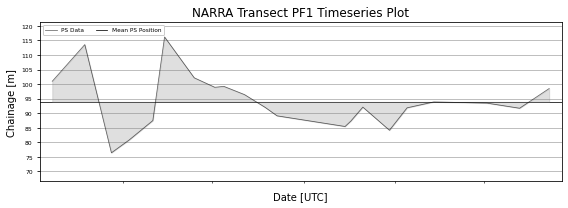

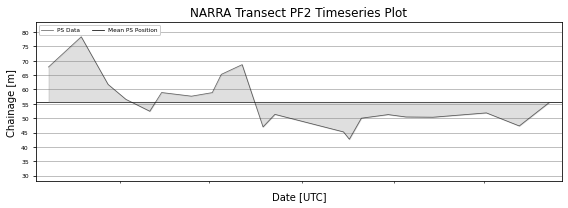

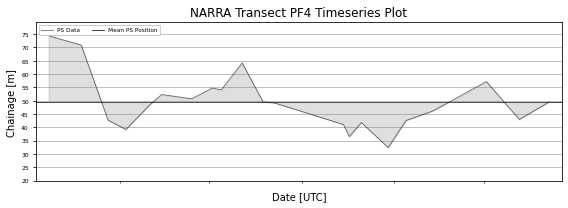

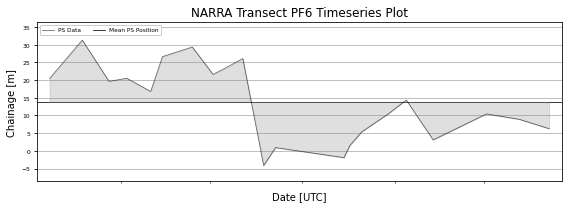

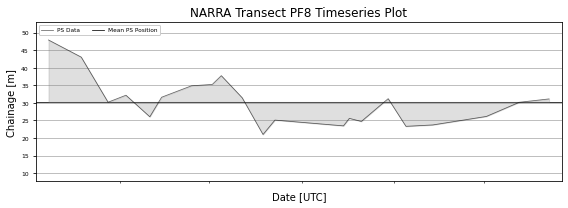

In [15]:
# loop through each transect and save a plot of the cross-shore shoreline change along that transect
for transect in settings['transects_load'].keys():
    ts_plot_single(settings, sl_csv_tide, transect,            
        # set savgol = True to plot 15 day moving average shoreline position
        # Requires > 15 day shorleine timeseries range
        savgol = False,
        # set x_scale for x-axis labels ['days', 'months', 'years']
        x_scale = 'years')